In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
from pylab import plt
import scipy.optimize as sco
plt.style.use("ggplot")

In [29]:
risk_free_rate = 0.03

stocks = ["HSBA.L", "RR.L", "BP.L", "BLND.L", "AV.L"]
num_assets = len(stocks)

yf_stock_data = yf.download(" ".join(stocks), start="2023-01-01", end="2024-01-01", rounding=True)["Close"]
yf_stock_data.to_csv("yf_stock_data.csv", index=True, header=True)

ftse_index = yf.download("^FTSE", start="2023-01-01", end="2024-01-01", progress=False, rounding=True)
ftse_index.to_csv("ftse_index.csv", index=True, header=True)

[*********************100%%**********************]  5 of 5 completed


In [30]:
raw_stock_data = pd.DataFrame(yf_stock_data)
raw_stock_data.fillna(method="ffill", inplace=True)
clean_stock_data = raw_stock_data

raw_ftse_data = pd.DataFrame(ftse_index)
raw_ftse_data.fillna(method="ffill", inplace=True)
clean_ftse_data = raw_ftse_data

clean_stock_data.head(), clean_ftse_data.head()

/var/folders/52/118zx6s92x5dv1www3l374100000gn/T/ipykernel_17436/2942537575.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_stock_data.fillna(method="ffill", inplace=True)
/var/folders/52/118zx6s92x5dv1www3l374100000gn/T/ipykernel_17436/2942537575.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_ftse_data.fillna(method="ffill", inplace=True)


(             AV.L  BLND.L    BP.L  HSBA.L    RR.L
 Date                                             
 2023-01-03  448.9   408.2  483.35   529.9   98.91
 2023-01-04  456.8   412.8  465.85   543.5  101.40
 2023-01-05  448.7   409.5  471.75   565.3  102.66
 2023-01-06  456.0   410.2  477.05   568.6  102.90
 2023-01-09  455.0   410.0  479.30   563.2  103.76,
               Open    High     Low   Close  Adj Close     Volume
 Date                                                            
 2023-01-03  7451.7  7626.4  7448.7  7554.1     7554.1  914070400
 2023-01-04  7554.1  7609.3  7545.2  7585.2     7585.2  753877000
 2023-01-05  7585.2  7658.8  7564.7  7633.5     7633.5  883850800
 2023-01-06  7633.5  7700.8  7633.5  7699.5     7699.5  813538800
 2023-01-09  7699.5  7725.7  7688.7  7724.9     7724.9  847858600)

In [31]:
stock_return = clean_stock_data.pct_change(periods=1)
stock_return.dropna(inplace=True)
stock_return.head()

,AV.L,BLND.L,BP.L,HSBA.L,RR.L
Date,,,,,
2023-01-04,0.017599,0.011269,-0.036206,0.025665,0.025174
2023-01-05,-0.017732,-0.007994,0.012665,0.040110,0.012426
2023-01-06,0.016269,0.001709,0.011235,0.005838,0.002338
2023-01-09,-0.002193,-0.000488,0.004716,-0.009497,0.008358
2023-01-10,0.007473,0.000488,-0.008763,0.001598,-0.026407


In [32]:
asset_return = stock_return.mean()
asset_return_annual = asset_return * 252
asset_cov = stock_return.cov()
asset_corr = stock_return.corr()

In [33]:
def portfolio_variance(weights):
    np_weights = np.array(weights)
    var = np_weights.T @ (asset_cov * 252) @ np_weights
    return var

def portfolio_volatility(weights):
    return np.sqrt(portfolio_variance(weights))

def portfolio_return(weights):
    return np.sum(asset_return * weights) * 252

def portfolio_sharpe_ratio(weights):
    return (portfolio_return(weights) - risk_free_rate) / portfolio_volatility(weights)

In [34]:
min_return = min(asset_return * 252)
max_return = max(asset_return * 252)
expected_returns = np.linspace(min_return, max_return, 100)
expected_volatility = []
weights = []
sharpe = []
initial_weights = np.ones(num_assets)
bnds = [(0, 1) for _ in range(num_assets)]

for i, expected_return in enumerate(expected_returns):
    cons = (
        {"type": "eq", "fun": lambda x: portfolio_return(x) - expected_return},
        {"type": "eq", "fun": lambda x: np.sum(x) - 1}
    )
    res = sco.minimize(portfolio_volatility, initial_weights, method="SLSQP", bounds=bnds, constraints=cons)
    frontier_weights = res["x"]
    frontier_return = portfolio_return(frontier_weights)
    expected_volatility.append(res["fun"])
    weights.append(frontier_weights)
    sharpe.append((frontier_return - risk_free_rate) / expected_volatility[-1])

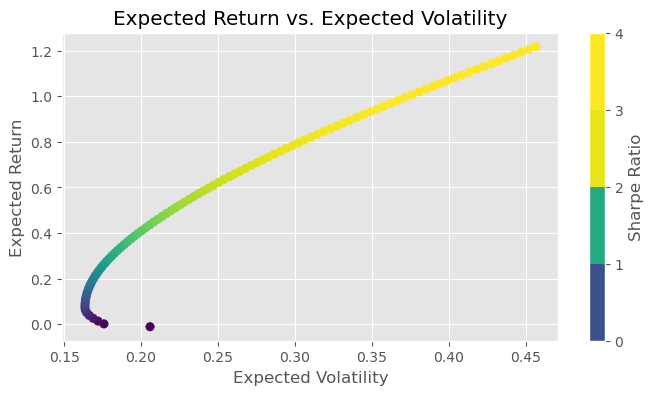

In [35]:
plt.figure(figsize=(8, 4))
plt.scatter(expected_volatility, expected_returns, c=(expected_returns - risk_free_rate) / expected_volatility, marker="o")
plt.grid(True)
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label="Sharpe Ratio", boundaries=np.linspace(0, 4, 5))
plt.title("Expected Return vs. Expected Volatility")
plt.show()

In [36]:
weights_end = pd.DataFrame(weights, columns=stocks)
weights_end.head()

,HSBA.L,RR.L,BP.L,BLND.L,AV.L
0,1.000000,9.619063e-17,0.000000,3.876904e-16,0.000000e+00
1,0.569669,1.367484e-01,0.276393,1.718968e-02,0.000000e+00
2,0.528521,1.355252e-01,0.260319,7.563466e-02,0.000000e+00
3,0.487368,1.341783e-01,0.244356,1.340984e-01,0.000000e+00
4,0.446242,1.327865e-01,0.228401,1.925704e-01,1.108092e-18


In [37]:
exp_volatility_end = pd.DataFrame(expected_volatility, columns=["Volatility"])
exp_returns_end = pd.DataFrame(expected_returns, columns=["Returns"])
sharpe_end = pd.DataFrame(sharpe, columns=["Sharpe"])

In [38]:
portfolio_end = pd.concat([weights_end, exp_volatility_end, exp_returns_end, sharpe_end], axis=1)
portfolio_end.head()

,HSBA.L,RR.L,BP.L,BLND.L,AV.L,Volatility,Returns,Sharpe
0,1.000000,9.619063e-17,0.000000,3.876904e-16,0.000000e+00,0.205801,-0.011203,-0.200208
1,0.569669,1.367484e-01,0.276393,1.718968e-02,0.000000e+00,0.175858,0.001205,-0.163741
2,0.528521,1.355252e-01,0.260319,7.563466e-02,0.000000e+00,0.171982,0.013613,-0.095285
3,0.487368,1.341783e-01,0.244356,1.340984e-01,0.000000e+00,0.168792,0.026020,-0.023577
4,0.446242,1.327865e-01,0.228401,1.925704e-01,1.108092e-18,0.166327,0.038428,0.050673


In [39]:
minimum_variance_portfolio = portfolio_end[portfolio_end["Volatility"]==portfolio_end["Volatility"].min()]
minimum_variance_portfolio

,HSBA.L,RR.L,BP.L,BLND.L,AV.L,Volatility,Returns,Sharpe
7,0.335261,0.129107,0.185108,0.346864,0.003659,0.163511,0.075652,0.279196


In [40]:
portfolio_end["Sharpe"].max()
optimal_portfolio = portfolio_end[portfolio_end["Sharpe"]==portfolio_end["Sharpe"].max()]
optimal_portfolio

,HSBA.L,RR.L,BP.L,BLND.L,AV.L,Volatility,Returns,Sharpe
91,1.110223e-16,0.0,0.0,0.098058,0.901942,0.417834,1.117906,2.603682


In [41]:
ftse_100 = pd.read_csv("ftse_index.csv", index_col=0, parse_dates=True, usecols=["Date", "Close"])
ftse_100.head()

,Close
Date,
2023-01-03,7554.1
2023-01-04,7585.2
2023-01-05,7633.5
2023-01-06,7699.5
2023-01-09,7724.9


In [42]:
market_return = ftse_100.pct_change(periods=1)
market_return.dropna(inplace=True)
market_return.head()

,Close
Date,
2023-01-04,0.004117
2023-01-05,0.006368
2023-01-06,0.008646
2023-01-09,0.003299
2023-01-10,-0.003935


In [43]:
market_return_mean = market_return.mean()
market_return_annual = market_return_mean * 252
market_return_annual

Close    0.030233
dtype: float64

In [44]:
market_beta = (market_return_mean * 252 - risk_free_rate) / market_return.std()
market_beta

Close    0.032125
dtype: float64

In [45]:
stock_beta = (stock_return.mean() * 252 - risk_free_rate) / stock_return.std()
stock_beta_end = pd.DataFrame(stock_beta, columns=["Beta"])
stock_beta_end

,Beta
AV.L,-3.178201
BLND.L,0.046680
BP.L,-1.817033
HSBA.L,13.342441
RR.L,41.290960


In [46]:
asset_return_end = pd.DataFrame(asset_return * 252, columns=["Return"])
asset_end = pd.concat([stock_beta_end, asset_return_end], axis=1)
asset_end

,Beta,Return
AV.L,-3.178201,-0.011203
BLND.L,0.046680,0.030959
BP.L,-1.817033,-0.000610
HSBA.L,13.342441,0.204891
RR.L,41.290960,1.217168


In [47]:
sml_slope = market_return_annual / market_beta

/var/folders/52/118zx6s92x5dv1www3l374100000gn/T/ipykernel_17436/820227119.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y1 = risk_free_rate + x1 * float(sml_slope)


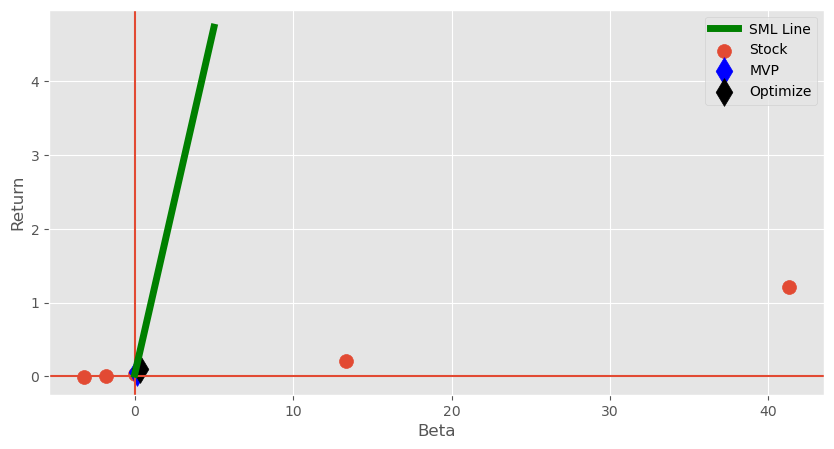

In [48]:
plt.figure(figsize=(10, 5))
plt.axvline(0)
plt.axhline(0)
x1 = np.linspace(0, 5, 256)
y1 = risk_free_rate + x1 * float(sml_slope)
plt.plot(x1, y1, color="g", linewidth=5, label="SML Line")
plt.scatter(asset_end["Beta"], asset_end["Return"], marker="o", s=100, label="Stock")
plt.scatter(0.130758,0.056586,color='b',marker='d',s=200,label='MVP')
plt.scatter(0.315409,0.09962,color='k',marker='d',s=200,label='Optimize')
plt.grid(True)
plt.xlabel('Beta')
plt.ylabel('Return')
plt.legend()
plt.show()
